Strategy Performance:
Start                         2025-05-06 10:57:00
End                           2025-05-20 04:01:00
Period                           13 days 17:05:00
Start Value                                1000.0
End Value                              773.989606
Total Return [%]                       -22.601039
Benchmark Return [%]                    13.710773
Max Gross Exposure [%]                  76.925794
Total Fees Paid                        272.565244
Max Drawdown [%]                         22.82768
Max Drawdown Duration            13 days 16:46:00
Total Trades                                34436
Total Closed Trades                         34303
Total Open Trades                             133
Open Trade PnL                          -0.049856
Win Rate [%]                            31.737749
Best Trade [%]                         187.751685
Worst Trade [%]                        -65.487614
Avg Winning Trade [%]                    1.351496
Avg Losing Trade [%]        

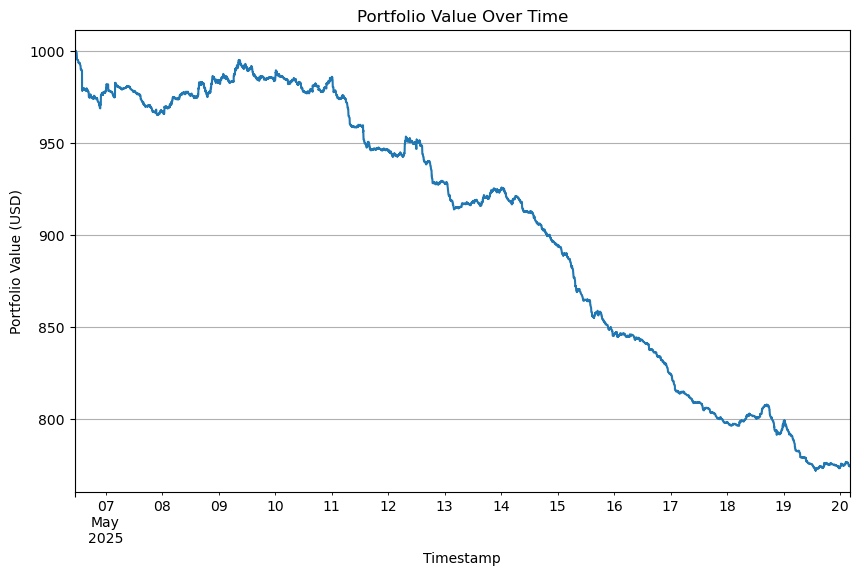

In [ ]:
import os
import sys
from datetime import datetime, timedelta
import pandas as pd
import ccxt
import vectorbt as vbt
import matplotlib.pyplot as plt

# --- Configuration ---
HIST_DIR = '/data/historical'
os.makedirs(HIST_DIR, exist_ok=True)

# Time window: last 14 days
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=14)
since = int(start_time.timestamp() * 1000)

# Initialize Binance US exchange via CCXT
exchange = ccxt.binanceus({'enableRateLimit': True})
try:
    exchange.load_markets()
except Exception as e:
    print(f"Error: Binance US markets not available. {e}")
    sys.exit(1)

# Filter spot symbols ending in USDT
symbols = [sym for sym, m in exchange.markets.items()
           if m.get('spot', False) and sym.endswith('/USDT')]

# Fetch or load OHLCV data for each symbol
ohlcv_data = {}
for symbol in symbols:
    filename = symbol.replace('/', '') + '.parquet'
    filepath = os.path.join(HIST_DIR, filename)

    if os.path.exists(filepath):
        df = pd.read_parquet(filepath)
    else:
        all_bars = []
        since_ts = since
        while True:
            try:
                bars = exchange.fetch_ohlcv(symbol, timeframe='1m', since=since_ts, limit=1000)
            except Exception as e:
                print(f"Warning: Failed to fetch OHLCV for {symbol}. Skipping. {e}")
                break
            if not bars:
                break
            all_bars.extend(bars)
            since_ts = bars[-1][0] + 60 * 1000
            if bars[-1][0] >= int(end_time.timestamp() * 1000):
                break

        if not all_bars:
            continue
        df = pd.DataFrame(all_bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df.loc[df.index >= start_time]
        df.to_parquet(filepath)

    ohlcv_data[symbol] = df

if not ohlcv_data:
    print("No market data available. Exiting.")
    sys.exit(1)

# Build DataFrames for close and low prices
price_df = pd.DataFrame({sym: df['close'] for sym, df in ohlcv_data.items()})
low_df   = pd.DataFrame({sym: df['low']   for sym, df in ohlcv_data.items()})
price_df.index.name = 'timestamp'
low_df.index.name   = 'timestamp'

# Calculate Bollinger Bands (20-period SMA, 2 std dev)
sma = price_df.rolling(window=20).mean()
rolling_std = price_df.rolling(window=20).std(ddof=0)
upper_band = sma + 2 * rolling_std
lower_band = sma - 2 * rolling_std

# Generate entry signals: price touches/exceeds upper band
entries = price_df >= upper_band

# Generate timed exit signals: 10 minutes after entry
timed_exits = entries.shift(2).fillna(False)

# Calculate entry price series to apply stop-loss
entry_price_df = price_df.where(entries).ffill()

# Generate stop-loss exit signals: price low drops 10% below entry price
stop_exits = low_df <= entry_price_df * 0.90

# Combine exit signals: either timed exit or stop-loss exit
exits = timed_exits | stop_exits

# Backtest: init $1000 total, 1% of portfolio per trade, 0.1% fees
pf = vbt.Portfolio.from_signals(
    close=price_df,
    entries=entries,
    exits=exits,
    init_cash=1000.0,
    fees=0.001,
    size=0.01, size_type='percent',  # use 'targetpercent' for percent sizing
    cash_sharing=True
)

# Display overall stats
print("Strategy Performance:")
print(pf.stats())

# Plot portfolio total value over time
plt.figure(figsize=(10, 6))
pf.value().plot()
plt.title('Portfolio Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.show()

# Optional: save stats and trades per asset
stats_df = pf.stats()
stats_df.to_csv('/data/bollinger_strategy_stats.csv')

for sym in ohlcv_data.keys():
    trades_sym = pf.trades[sym].records_readable
    trades_sym.to_csv(f"/data/{sym.replace('/', '')}_trades.csv", index=False)
